In [ ]:
  import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import io
import matplotlib.pyplot as plt

# Load the Dataset

In [ ]:
(train_data, test_data), dataset_info = tfds.load('yelp_polarity_reviews', split=['train','test'], shuffle_files=True, with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/560000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/yelp_polarity_reviews/incomplete.DRDJQ7_0.2.0/yelp_polarity_reviews-train.…

Generating test examples...:   0%|          | 0/38000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/yelp_polarity_reviews/incomplete.DRDJQ7_0.2.0/yelp_polarity_reviews-test.t…

Dataset yelp_polarity_reviews downloaded and prepared to /root/tensorflow_datasets/yelp_polarity_reviews/0.2.0. Subsequent calls will reuse this data.


# Data Exploration

In [ ]:
def get_reviews(dataset, num_samples=5):
  reviews=[]
  for text, labels in dataset.take(num_samples):
    reviews.append((text.numpy().decode('utf-8'), labels.numpy()))

  return reviews


def dataset_insights(dataset, num_samples=2500):
  total_reviews = 0
  pos_reviews = 0
  neg_reviews = 0
  total_len = 0
  min_len = float('inf')
  max_len = 0

  for text, labels in dataset.take(num_samples):
    total_reviews += 1
    review_len = len(text.numpy().decode('utf-8').split())
    total_len += review_len
    if review_len < min_len:
      min_len = review_len
    if review_len > max_len:
      max_len = review_len

    if labels.numpy() == 1:
      pos_reviews += 1
    else:
      neg_reviews += 1

  avg_len = total_len / total_reviews

  return total_reviews, pos_reviews, neg_reviews, avg_len, min_len, max_len

def plot_reviews(positive, negative):
  labels=['Positive','Negative']
  counts=[positive,negative]
  plt.bar(labels, counts, color=['blue','red'])
  plt.xlabel('Review Type')
  plt.ylabel('Number of Reviews')
  plt.title('Sentiment Distribution')
  plt.show()

In [ ]:
print("Training set reeviews")
train_reviews = get_reviews(train_data, 7)

for review, label in train_reviews:
  print(f'labels :{label}, review: {review[:100]}')

Training set reeviews
labels :1, review: The Groovy P. and I ventured to his old stomping grounds for lunch today.  The '5 and Diner' on 16th
labels :1, review: If you want to be on the strip, this isn't the place for you.  I have never stayed on the strip in V
labels :1, review: A great place to shop in Vegas, one of my favorite places to break my wallets in...\r\n\r\nI don't g
labels :1, review: First time trying this place out...ordered the Aloha Chicken! :-) The food was pretty good...althoug
labels :0, review: It was bad. My nails are ruined. I asked for purple and sparkles and they gave me nothing near that.
labels :1, review: My wife ordered bun tom thit nuong, also known as old #43 -   charbroiled shrimp & egg roll with ric
labels :1, review: Great club! Patrons be weary . . . We attended this club when Diddy was hosting and everybody knows 


In [ ]:
total_reviews, pos_reviews, neg_reviews, avg_len, min_len, max_len = dataset_insights(train_data)

print(f"Shortest Review Length: {min_len}")
print(f"Longest Review Length: {max_len}")
print(f"Average Review Length: {avg_len:.2f}")
print(f"Total Positive Reviews: {pos_reviews}")
print(f"Total Negative Reviews: {neg_reviews}")
print(f"Total Reviews: {total_reviews}")

Shortest Review Length: 1
Longest Review Length: 942
Average Review Length: 131.13
Total Positive Reviews: 1267
Total Negative Reviews: 1233
Total Reviews: 2500


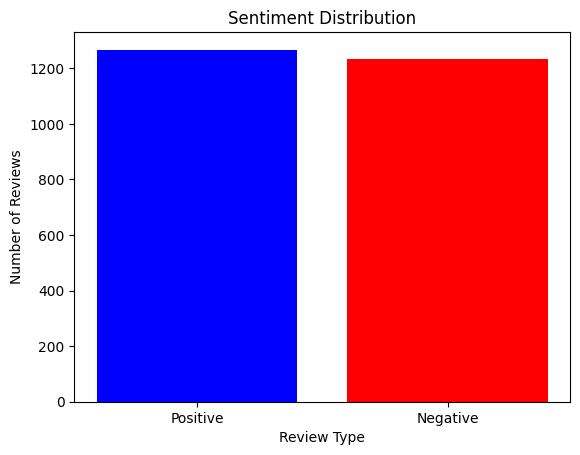

In [ ]:
plot_reviews(pos_reviews,neg_reviews)

# Preparing Data

In [ ]:
# Build tokenizer

tokenizer = Tokenizer(num_words = 10000, oov_token='<OOV>') # vocab size is 10000 words

In [ ]:
# fetch and decode trainig data
train_text = []
train_labels = []

for example in train_data.take(20000):
  text, label = example
  train_text.append(text.numpy().decode('utf-8'))
  train_labels.append(label.numpy())

#convert labels to numpy array
train_labels = np.array(train_labels)

#fit the tokenizer on the training text
tokenizer.fit_on_texts(train_text)

# get word index
word_index = tokenizer.word_index

#convert text to sequence
train_seq = tokenizer.texts_to_sequences(train_text)

In [ ]:
test_labels = []
test_text = []

for example in test_data.take(8000):
  text, label =example
  test_text.append(text.numpy().decode('utf-8'))
  test_labels.append(label.numpy())

test_labels = np.array(test_labels)

tokenizer.fit_on_texts(test_text)
test_seq = tokenizer.texts_to_sequences(test_text)

In [ ]:
#pad the sequence

train_pad = pad_sequences(train_seq, maxlen=132, padding = 'post', truncating = 'post')
test_pad = pad_sequences(test_seq, maxlen=132, padding = 'post', truncating = 'post')

In [ ]:
# spliting data into training and validation

train_pad, val_pad, train_labels, val_labels = train_test_split(train_pad, train_labels, test_size=0.2, random_state=108)

# Building sentiment model

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_len = 132

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_len),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_pad, train_labels, epochs=10, validation_data=(val_pad, val_labels))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6405 - loss: 0.6469 - val_accuracy: 0.7983 - val_loss: 0.4219
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8621 - loss: 0.3548 - val_accuracy: 0.8773 - val_loss: 0.3045
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8982 - loss: 0.2572 - val_accuracy: 0.8827 - val_loss: 0.2776
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9200 - loss: 0.2094 - val_accuracy: 0.8900 - val_loss: 0.2707
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9330 - loss: 0.1864 - val_accuracy: 0.8917 - val_loss: 0.2790
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9351 - loss: 0.1721 - val_accuracy: 0.8928 - val_loss: 0.2761
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9505 - loss: 0.1447 - val_accuracy: 0.8882 - val_loss: 0.2904
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9541 - loss: 0.1347 - val_accuracy: 0.8857 - val_

In [ ]:
results = model.evaluate(test_pad,test_labels) #model ias overfittied

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5398 - loss: 1.3974


In [ ]:
results[0],results[1]

(1.3990265130996704, 0.5403749942779541)

In [ ]:
def plot_history(history):
  plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['train','validation'])

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['train','validation'])

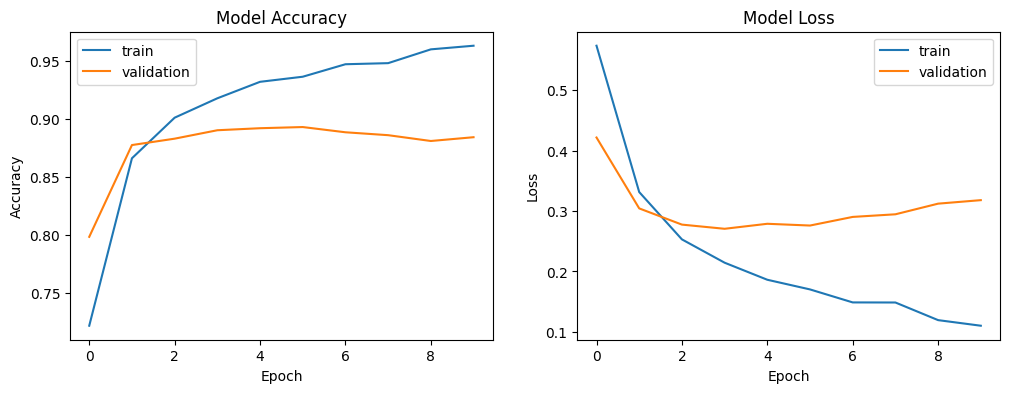

In [ ]:
plot_history(history)

In [ ]:
new_sentences = ["The restaurant was absolutely fantastic. The staff were kind and the food was delicious.",  # positive
    "I've had an incredible day at the beach, the weather was beautiful.",  # positive
    "The movie was a big disappointment. I wouldn't recommend it to anyone.",  # negative
    "I bought a new phone and it stopped working after a week. Terrible product."  # negative
]

In [ ]:
# preprocesses the sentence in the same as training data

new_seq = tokenizer.texts_to_sequences(new_sentences)
new_pad = pad_sequences(new_seq, maxlen=132, padding='post', truncating='post')

prediction = model.predict(new_pad)

for i in range(len(new_sentences)):
  print('sequence :',new_seq[i])
  print('predicted sentiment', prediction[i])

  if prediction[i]>0.5:
    print('positive')
  else:
    print('negative')
  print('\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
sequence : [2, 106, 7, 503, 566, 2, 125, 27, 301, 3, 2, 31, 7, 186]
predicted sentiment [0.37064046]
negative


sequence : [112, 25, 60, 1263, 149, 26, 2, 3272, 2, 1957, 7, 646]
predicted sentiment [0.8121602]
positive


sequence : [2, 1164, 7, 5, 224, 1114, 4, 457, 234, 9, 6, 495]
predicted sentiment [0.71738696]
positive


sequence : [4, 733, 5, 162, 441, 3, 9, 669, 511, 83, 5, 388, 472, 1358]
predicted sentiment [0.4544695]
negative




# Embedding visualization

In [ ]:
#get embedding layer weights
weights = model.get_layer('embedding').get_weights()[0]

vocab = tokenizer.word_index
print(weights.shape) #(vocab_size, embedding_dim)

(10000, 16)


In [ ]:
#save the weigths and vocabulary

out_v = io.open('vetors.tsv','w',encoding='utf-8')
out_m = io.open('metadata.tsv','w',encoding='utf-8')

for word, index in vocab.items():
  if index < vocab_size:
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + '\n')
    out_m.write(word + '\n')

out_v.close()
out_m.close()

# Improving the performance of the model

Increasing vocab_size

In [ ]:
vocab_size = 20000 # increasing the vocab_size
embedding_dim = 16
max_len = 132

model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_len),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_1 = model_1.fit(train_pad, train_labels, epochs=10, validation_data=(val_pad, val_labels))

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6152 - loss: 0.6551 - val_accuracy: 0.8370 - val_loss: 0.4336
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8409 - loss: 0.3878 - val_accuracy: 0.8750 - val_loss: 0.3190
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8936 - loss: 0.2778 - val_accuracy: 0.8577 - val_loss: 0.3115
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9099 - loss: 0.2359 - val_accuracy: 0.8765 - val_loss: 0.2816
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9208 - loss: 0.2093 - val_accuracy: 0.8900 - val_loss: 0.2775
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9371 - loss: 0.1762 - val_accuracy: 0.8860 - val_loss: 0.2790
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9431 - loss: 0.1624 - val_accuracy: 0.8917 - val_loss: 0.2796
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9477 - loss: 0.1435 - val_accuracy: 0.

In [ ]:
model_1.evaluate(test_pad,test_labels)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5188 - loss: 1.3952


[1.3963967561721802, 0.5217499732971191]

Increasing embedding dimension

In [ ]:
vocab_size = 20000 # increasing the vocab_size to 20000
embedding_dim = 32 # increasing the embedding dim to 32
max_len = 132

model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_len),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_2 = model_2.fit(train_pad, train_labels, epochs=10, validation_data=(val_pad, val_labels))

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6436 - loss: 0.6337 - val_accuracy: 0.8285 - val_loss: 0.3761
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8629 - loss: 0.3260 - val_accuracy: 0.8702 - val_loss: 0.3074
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9034 - loss: 0.2448 - val_accuracy: 0.8497 - val_loss: 0.3295
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9193 - loss: 0.2089 - val_accuracy: 0.8875 - val_loss: 0.2719
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9309 - loss: 0.1769 - val_accuracy: 0.8880 - val_loss: 0.2747
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9442 - loss: 0.1548 - val_accuracy: 0.8850 - val_loss: 0.2953
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9561 - loss: 0.1266 - val_accuracy: 0.8737 - val_loss: 0.3210
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9595 - loss: 0.1191 - val_accuracy: 0

In [ ]:
model_2.evaluate(test_pad,test_labels)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5214 - loss: 1.5828


[1.5854718685150146, 0.5205000042915344]

Increasing training data

In [ ]:
train_text = []
train_labels = []

for example in train_data.take(40000):
  text, label = example
  train_text.append(text.numpy().decode('utf-8'))
  train_labels.append(label.numpy())

#convert labels to numpy array
train_labels = np.array(train_labels)

#fit the tokenizer on the training text
tokenizer.fit_on_texts(train_text)

# get word index
word_index = tokenizer.word_index

#convert text to sequence
train_seq = tokenizer.texts_to_sequences(train_text)

In [ ]:
test_labels = []
test_text = []

for example in test_data.take(16000):
  text, label =example
  test_text.append(text.numpy().decode('utf-8'))
  test_labels.append(label.numpy())

test_labels = np.array(test_labels)

tokenizer.fit_on_texts(test_text)
test_seq = tokenizer.texts_to_sequences(test_text)

In [ ]:
#pad the sequence

train_pad = pad_sequences(train_seq, maxlen=132, padding = 'post', truncating = 'post')
test_pad = pad_sequences(test_seq, maxlen=132, padding = 'post', truncating = 'post')

In [ ]:
# spliting data into training and validation

train_pad, val_pad, train_labels, val_labels = train_test_split(train_pad, train_labels, test_size=0.2, random_state=108)

In [ ]:
vocab_size = 20000 # increasing the vocab_size
embedding_dim = 16
max_len = 132

model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_len),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_3 = model_3.fit(train_pad, train_labels, epochs=10, validation_data=(val_pad, val_labels))

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6843 - loss: 0.5805 - val_accuracy: 0.8763 - val_loss: 0.3118
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8874 - loss: 0.2731 - val_accuracy: 0.8855 - val_loss: 0.2745
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9153 - loss: 0.2207 - val_accuracy: 0.8950 - val_loss: 0.2638
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9246 - loss: 0.1929 - val_accuracy: 0.8723 - val_loss: 0.2988
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9322 - loss: 0.1763 - val_accuracy: 0.8716 - val_loss: 0.3089
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9372 - loss: 0.1655 - val_accuracy: 0.8945 - val_loss: 0.2746
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9467 - loss: 0.1463 - val_accuracy: 0.8941 - val_loss: 0.2831
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9503 - loss: 0.1407 -

In [ ]:
model_3.evaluate(test_pad,test_labels)

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6094 - loss: 1.2343


[1.204919695854187, 0.6151250004768372]

Dropout Regularization

In [ ]:
vocab_size = 20000 # increasing the vocab_size
embedding_dim = 16
max_len = 132

model_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_len),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_4 = model_4.fit(train_pad, train_labels, epochs=10, validation_data=(val_pad, val_labels))

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6537 - loss: 0.6188 - val_accuracy: 0.8741 - val_loss: 0.3274
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8728 - loss: 0.3208 - val_accuracy: 0.8820 - val_loss: 0.2837
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9025 - loss: 0.2646 - val_accuracy: 0.8960 - val_loss: 0.2628
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9194 - loss: 0.2282 - val_accuracy: 0.8921 - val_loss: 0.2643
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9273 - loss: 0.2063 - val_accuracy: 0.8790 - val_loss: 0.2935
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9377 - loss: 0.1930 - val_accuracy: 0.8946 - val_loss: 0.2723
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9431 - loss: 0.1724 - val_accuracy: 0.8924 - val_loss: 0.2823
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9482 - loss: 0.1656 -

In [ ]:
model_4.evaluate(test_pad,test_labels)

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6238 - loss: 1.2096


[1.1702344417572021, 0.6321874856948853]

Try different optimizer

In [ ]:
vocab_size = 20000 # increasing the vocab_size
embedding_dim = 16
max_len = 132

model_5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_len),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_5.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])

history_5 = model_5.fit(train_pad, train_labels, epochs=10, validation_data=(val_pad, val_labels))

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6010 - loss: 0.6622 - val_accuracy: 0.7980 - val_loss: 0.4605
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8109 - loss: 0.4349 - val_accuracy: 0.8555 - val_loss: 0.3336
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8605 - loss: 0.3312 - val_accuracy: 0.8639 - val_loss: 0.3133
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8759 - loss: 0.3025 - val_accuracy: 0.8886 - val_loss: 0.2778
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8879 - loss: 0.2849 - val_accuracy: 0.8134 - val_loss: 0.4210
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8941 - loss: 0.2673 - val_accuracy: 0.8903 - val_loss: 0.2694
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8999 - loss: 0.2621 - val_accuracy: 0.8796 - val_loss: 0.2869
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9037 - loss: 0.2459 -

In [ ]:
model_5.evaluate(test_pad,test_labels)

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6459 - loss: 0.8744


[0.8524788022041321, 0.6545000076293945]